# 2D FDTD with fdtdx: Plane Source & Cylinder

Currently in FDTDX, 2d simulations are not natively supported however one can create them using the steps mentioned in this notebook. Here, we simulate a **2D electromagnetic problem** by using a 3-cell extruded geometry:
- The simulation volume is 3 cells thick in the **third (z) axis**.
- Cells at index 0 and 2 in z have **periodic boundaries** to mimic 2D.
- All objects are uniform in the z-direction so the fields also behave 2D.

Note: Some special sources (mode / gaussian plane sources) may not currently work in this 2D trick. But a standard plane source does.

---

## Imports & Setup


In [401]:
import fdtdx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import Video
%matplotlib inline


## Simulation Configuration

Here we define:
- Type of the Material we want and the permittivity value.
- Simulation Config with some basic information on how long the simulation should run and how accurate it needs to be (resolution, dtype and courant factor).
- boundary conditions

In [404]:
# 1) Basic FDTD config
config = fdtdx.SimulationConfig(
    time=100e-15,           # total simulated time
    resolution=50e-9,       # spatial resolution
    dtype=jnp.float32,
    courant_factor=0.99,
)

material = fdtdx.Material(permittivity=1.0)

materials = {
    "air": material,
    "cylinder": fdtdx.Material(permittivity=2.25),
}


# create a volume that is large in x/y, thin in z
volume = fdtdx.SimulationVolume(
    partial_real_shape=(8e-6, 4e-6, 0.3e-6),  # ~3 cells in z
    material=material
)

# --- Compute grid cell counts manually ---
dx = config.resolution
nx = int(volume.partial_real_shape[0] / dx)
ny = int(volume.partial_real_shape[1] / dx)
nz = int(volume.partial_real_shape[2] / dx)


We enforce **periodic boundaries** in z (first and last slice) so the simulation imitates 2D in x-y.

Periodicity in fdtdx is set via boundary configs (or can be manually added).


In [407]:
# create periodic boundaries in z
bound_cfg = fdtdx.BoundaryConfig.from_uniform_bound(
    thickness=1, 
    boundary_type="periodic"
)
bound_dict, bc_constraints = fdtdx.boundary_objects_from_config(bound_cfg, volume)


## Plane Source

We now place a **plane source** that emits light along +x into the domain.  
Note: We use a standard `UniformPlaneSource`; mode source not supported in this 2D trick yet.

This source is extruded in z, so it is uniform along that axis. Here, we will also intiliaze the objects and constraints as lists which will be help us appending various functions.


In [410]:
from fdtdx import UniformPlaneSource, WaveCharacter

source = fdtdx.UniformPlaneSource(
fixed_E_polarization_vector=(0,0,1),
partial_grid_shape=(1, None, None),
partial_real_position=(0.0, None, None),  # x = 0, span y/z
wave_character=fdtdx.WaveCharacter(wavelength=1.55e-6),
direction="+",
name="plane_source",
)

objects = []
constraints = []

## Cylinder (scatterer)

We place a **cylinder** in the center. This object extends fully in z, so in 2D view it is a circle.

Note: fdtdx’s `Cylinder` extrudes along one axis (here z) to make a 2D circle when looked in x-y.


In [413]:
cyl = fdtdx.Cylinder(
    partial_real_shape=(0.5e-6, 0.5e-6, 0.3e-6),
    radius=0.25e-6,
    axis=2,
    materials=materials,
    material_name="cylinder",
    name="cylinder",
)



Let's assemble all the objects and constraints in our lists.

In [416]:
# Assemble objects and constraints
objects.append(volume)
objects.append(source)

# add boundary objects + constraints (FIX)
for val in bound_dict.values():
    if isinstance(val, tuple):
        bound_obj, bound_constraint = val
        objects.append(bound_obj)
        constraints.append(bound_constraint)
    else:
        # periodic boundary (object only)
        objects.append(val)

# add cylinder + its constraint
objects.append(cyl)
constraints.append(cyl.place_at_center(volume))
constraints.extend(
    source.same_position_and_size(volume, axes=(1, 2))
)

In order to actually see a result from the simulation, we need to define a Detector.

Here we use an EnergyDetector, which calculates the energy at every grid point within its volume. We also speciy a switch, which controls the time steps that the detector records. Our purpose here is to generate a video of the energy during the simulation. We do not need every single time step for this, so we only record every fifth time step.

In [419]:
video_detector = fdtdx.EnergyDetector(
    name="Ez_video",
    switch=fdtdx.OnOffSwitch(interval=5)
)
objects.append(video_detector)
constraints.extend(video_detector.same_position_and_size(volume))

## Place Objects & Build Scene

Now compute actual positions for all objects.


In [422]:
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)

objs, arrays, params, config, _ = fdtdx.place_objects(
object_list=objects,
config=config,
constraints=constraints,
key=subkey,
)


<Figure size 800x600 with 0 Axes>

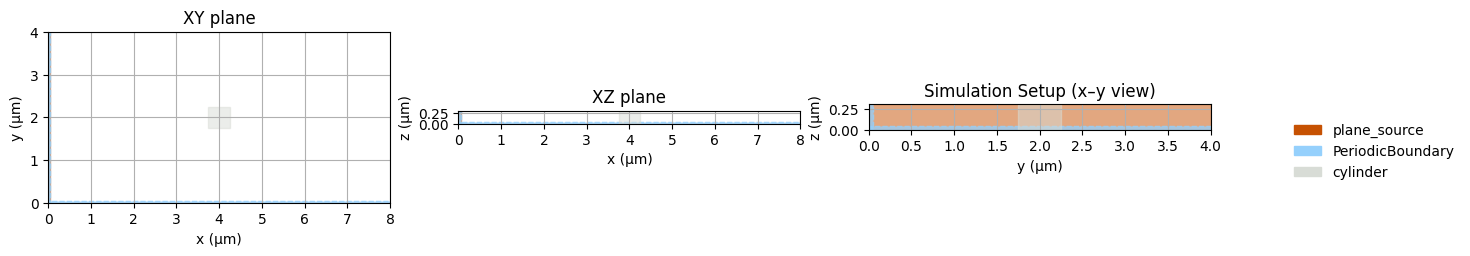

In [424]:
plt.figure(figsize=(8, 6))
fdtdx.plot_setup(config=config, objects = objs, exclude_object_list=[video_detector])
plt.title("Simulation Setup (x–y view)")
plt.show()

<Figure size 800x600 with 0 Axes>

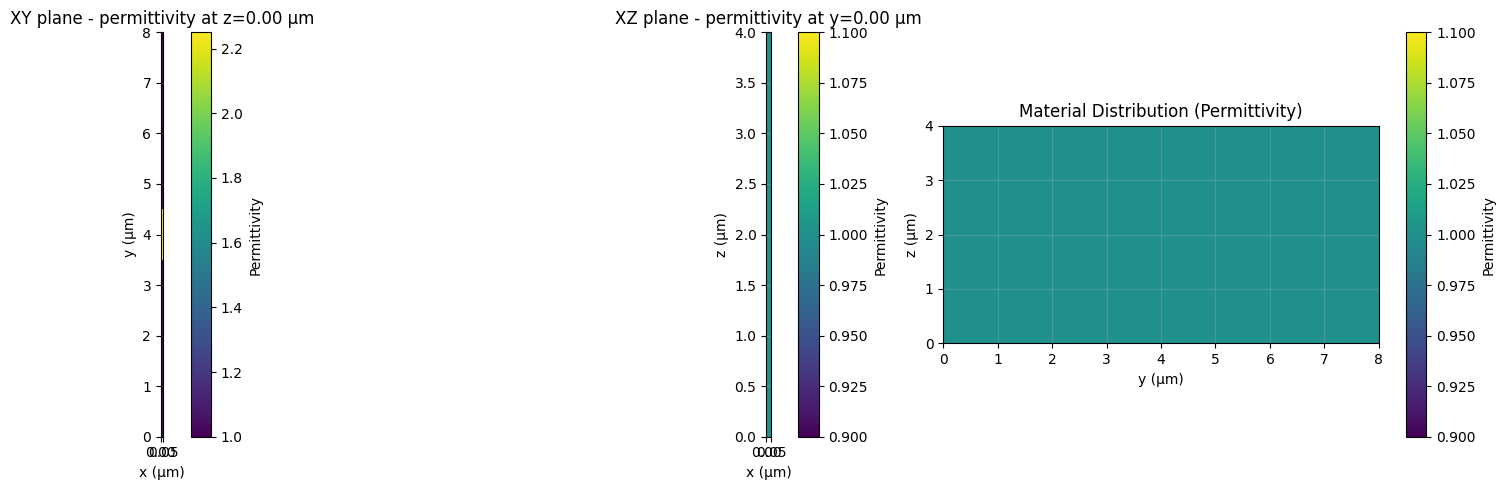

In [426]:
from fdtdx.utils.plot_material import plot_material


plt.figure(figsize=(8, 6))
plot_material(
    arrays=arrays,
    config=config,
)
plt.title("Material Distribution (Permittivity)")
plt.tight_layout()
plt.show()


## Running the Simulation

Now let's define a function that actually runs the simulation. In FDTDX, this is a two-part process.

Firstly, we call apply_params, which performs some calculations before the start of the simulation. If we have some parametric objects in the simulation, this function applies the given parameters and calculates the actual shapes of these objects. Additionally, some performance optimization are done here by calculating values for the simulation once before the simulation starts

Then, we call run_fdtd, which performs the FDTD simulation as a loop. The computation terminates as soon as the required number of time steps are reached.


In [429]:
key, subkey = jax.random.split(key)

arrays, new_objects, info = fdtdx.apply_params(arrays, objs, params, key)

final_timestamp, new_arrays = fdtdx.run_fdtd(
    config=config,
    objects=new_objects,
    arrays=arrays,
    key=key
)


## Visualizing the Simulation

Now we have run the simulation, but how do we visualize the results? Our goal was to generate a video of the simulation, so let's do this.

The syntax for generating a video in a jupyter notebook is currently a bit complicated, but for actual scripts FDTDX offers some utility functions to make this easier. The reason the syntax is so complicated, is on the one hand because of the JAX-syntax which does not allow in-place updates. Additionally, the plot function saves a video to a temporary location. We can either access the video from there or move it to a more permament location

In [432]:
# get the recorded detector state
detector_state = new_arrays.detector_states["Ez_video"]

# generate video (mp4)
video_path = new_objects["Ez_video"].draw_plot(detector_state)

print(video_path)
Video(list(video_path.values())[0], embed=True, width=720)


{'energy': '/var/folders/9c/sf1_5nb17v51rk1l8xcxshdc0000gn/T/tmp9w9idaoc.mp4'}
